In [57]:
"""
DNN Experiments Serrano/AUDSOME Phase 1
Anomaly Only
AUdsome Anomaly
Gabriel Iuhasz
"""
import os
# limit GPU allocation
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #issue #152
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


# from sklearn.externals import joblib
from joblib import dump, load
import json
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from subprocess import check_output
%matplotlib inline

In [58]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, digits=4, target_names=definitions))
    report = classification_report(y, y_pred, digits=4, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [59]:
print("Checking files in data location ...")
# train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
# train_dir = '/home/gabriel/research/dipet/serrano/data'
train_dir = '/home/gabriel/Research/Aspide/workspace/v2/experiments/ede_exp/notebooks/exp_dss/movedfromkraken/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models



In [60]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [61]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [62]:
print("Dataset chosen ...")
data = df_audsome

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(4800, 90)

In [63]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [64]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


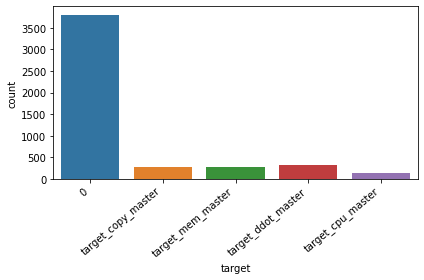

In [65]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [66]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


Starting of experiment for DNN only

Parameters:



In [67]:
# Name of experiment
# DNN
prefix = 'Phase1_dnn_evs_audsome'
dnn = True # needed for special reporting features
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.utils import plot_model

paramgrid = {
    "optimizer": ["adam", "adagrad", "sgd"],
    "learning_r": [0.01, 0.0001 , 0.003, 0.001],
    "patience" : [4],
    "batch_size": [512], # use yellowbrick
    "epochs": [300],
    "kernel_init": ['he_uniform', 'he_normal'],
    "layer_1": [0, 50, 100],
    "layer_2": [0,  50, 100],
    "layer_3": [0,  50, 100],
    "layer_0": [0, 200, 100, 50],
    "drop": [0, 0.1, 0.2, 0.3, 0.4],
    "loss": ["categorical_crossentropy"],
    "activation_1": ['relu', 'elu', 'selu'],
    "out_activation":["sigmoid"]
}

y_oh = pd.get_dummies(y, prefix='target')

# Reverse one hot encoding
def reverse_oh(y_oh):
    decode = []
    for r in y_oh:
        # print(r)
        result = np.where(r == 1.)[0]
        # print(result)
        #check if network asigned more than one or non labels
        if len(result) > 1 or len(result) == 0:
            if len(result) > 1:
                result = np.array([result[0]])  # select first class
            elif len(result) == 0:
                result = np.array([0])

        decode.append(result[0])
    return decode


def dnn_aspide(optimizer='adam', #adam, adagrad, sgd
               learning_r = 0.01,
              patience=5,
              batch_size=32,
              epochs=1000,
              kernel_init='he_uniform',
              layer_1 = 20,
              layer_2 = 40,
              layer_3 = 40,
              layer_0 = 100,
              drop = 0.1,
              loss='categorical_crossentropy',
              activation_1 = 'relu', # elu, selu
              out_activation='sigmoid'):
    y_oh = pd.get_dummies(y, prefix='target')
#     print(np.asarray(X).shape[1], len(y_oh.nunique()))
#     print(len(y_oh.nunique()))
    n_inputs, n_outputs = X.shape[1], len(y_oh.nunique()) # if unique is lower than acutal len(y_oh.nunique()) might not work
    model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=2,activation=activation_1, input_shape=n_inputs, kernel_initializer=kernel_init))
    model.add(Dense(layer_0, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
    if drop:
        model.add(Dropout(drop))
    if layer_1:
        model.add(Dense(layer_1, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_2:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_3:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    model.add(Dense(n_outputs, activation=out_activation))
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_r)
    if optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_r)
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_r)
    else:
        opt = Adam(learning_rate=0.01)
    model.compile(optimizer = opt, loss=loss, metrics=['accuracy', 'categorical_crossentropy', 'binary_crossentropy'])
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(np.asarray(X), np.asarray(y_oh),
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    # df_history = pd.DataFrame(h.history)
    # df_history
    return model



# model_v = dnn_aspide()
# model_v.summary()
model = KerasClassifier(build_fn=dnn_aspide, verbose=0)


In [68]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
# scorer = 'accuracy'
n_splits = 2 # default 4

# cv_type = StratifiedKFold(n_splits=n_splits)
cv_type = None
nj = 1 # Number of jobs set to 1 for DNN

cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=paramgrid,
                                   scoring=scorer,
                                   cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
                                   verbose=4,
                                   population_size=20, # 40
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=4,
                                   generations_number=10, #10
                                   n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8

/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [69]:
cv.fit(np.asarray(X), np.asarray(y))

Types [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] and maxint [2, 3, 0, 0, 0, 1, 2, 2, 2, 3, 4, 0, 2, 0] detected
--- Evolve in 38880 possible combinations ---
[CV] END activation_1=relu, batch_size=512, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.382 total time=  10.6s
[CV] END activation_1=relu, batch_size=512, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.683 total time=  13.1s
[CV] END activation_1=relu, batch_size=512, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.425 total time=  11.7s
[CV] END activation_

In [70]:
# Remove bool values from dict
# cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
try:
    dump(cv.best_estimator_, os.path.join(model_dir,model_name))
except:
    cv.best_estimator_.model.save(f"{model_name}.hdf5")

Saving CV results
Phase1_dnn_evs_audsome best params: {'optimizer': 'sgd', 'learning_r': 0.01, 'patience': 4, 'batch_size': 512, 'epochs': 300, 'kernel_init': 'he_uniform', 'layer_1': 50, 'layer_2': 50, 'layer_3': 50, 'layer_0': 100, 'drop': 0, 'loss': 'categorical_crossentropy', 'activation_1': 'selu', 'out_activation': 'sigmoid'}
Phase1_dnn_evs_audsome best score: 0.9884493244857155
Saving best Phase1_dnn_evs_audsome estimator


In [71]:
y_pred = cv.best_estimator_.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


Accuracy score is: 0.9954166666666666
Ballanced accuracy score is: 0.9788331656368048
Jaccard score (micro): 0.9908751555371216
Jaccard score (macro): 0.9684825938482378
Jaccard score (weighted): 0.9909457137062728
Full classification report
                    precision    recall  f1-score   support

                 0     0.9971    1.0000    0.9986      3803
target_copy_master     0.9963    0.9888    0.9925       269
 target_mem_master     0.9924    0.9739    0.9831       268
target_ddot_master     0.9874    0.9874    0.9874       317
 target_cpu_master     0.9712    0.9441    0.9574       143

          accuracy                         0.9954      4800
         macro avg     0.9889    0.9788    0.9838      4800
      weighted avg     0.9954    0.9954    0.9954      4800

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9971    1.0000    0.9890    0.9986    0.9945    0.9901      3803
t

Confusion matrix


,loss,accuracy,categorical_crossentropy,binary_crossentropy
0,0.028551,0.993333,0.028551,0.367405
1,0.027858,0.993958,0.027858,0.372049
2,0.027923,0.993750,0.027923,0.367734
3,0.027857,0.994167,0.027857,0.364859
4,0.027748,0.993958,0.027748,0.379294
...,...,...,...,...
295,0.016657,0.995208,0.016657,0.371603
296,0.016831,0.995417,0.016831,0.369528
297,0.016696,0.995208,0.016696,0.375686
298,0.016714,0.995417,0.016714,0.365251


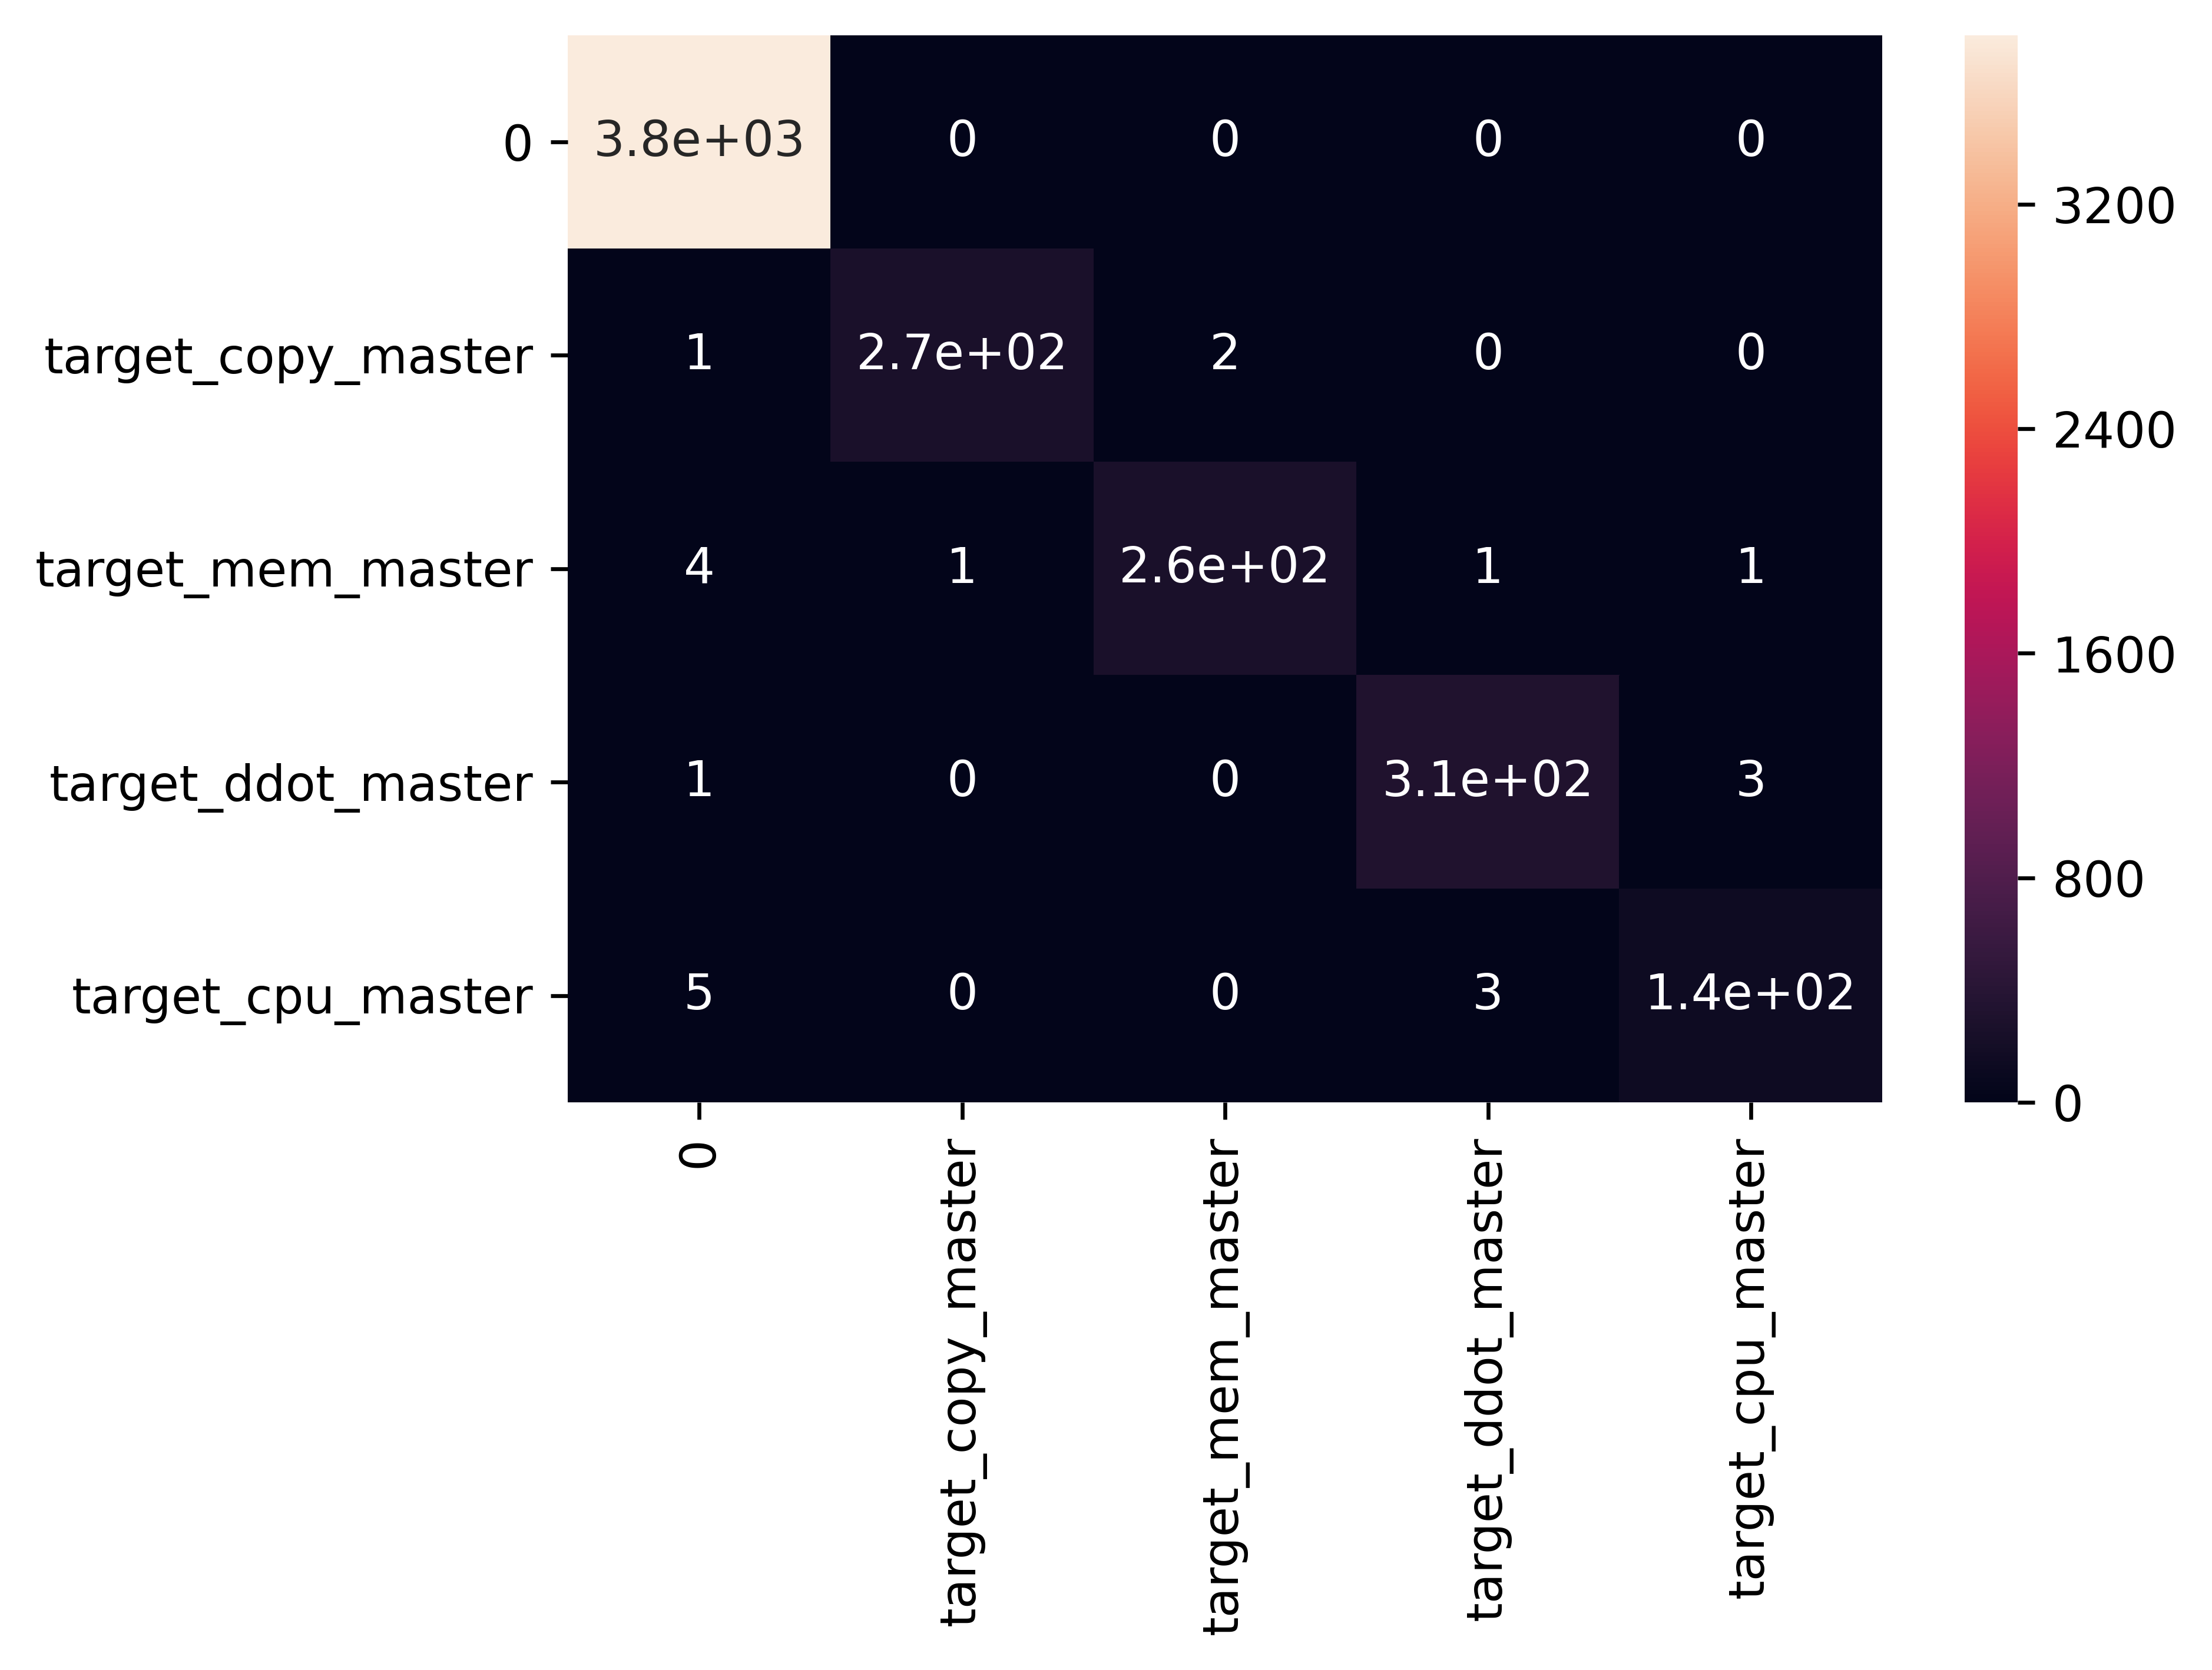

In [72]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
plt.figure(dpi=600)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig), format='pdf',
           bbox_inches='tight', pad_inches=0)


# DNN history export
df_history = pd.DataFrame(cv.best_estimator_.model.history.history)
history_name = "{}_history.csv".format(prefix)
df_history.to_csv(os.path.join(model_dir, history_name), index=False)
df_history
# Extract Feature importance
# feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
# featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
# feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# # print(feat_importances.head(10))
# sorted_feature = feat_importances.sort_values(ascending=True)
# # Plot the feature importances of the forest
# # plt.figure()
# plt.figure(figsize=(10,20), dpi=600)
# plt.title("Feature importances")
# plt.barh(range(X.shape[1]), sorted_feature,
#        color="r", align="center", )
# # If you want to define your own labels,
# # change indices to a list of labels on the following line.
# plt.yticks(range(X.shape[1]), sorted_feature.index)
# plt.ylim([-1, X.shape[1]])
# plt.show()


Saving topology


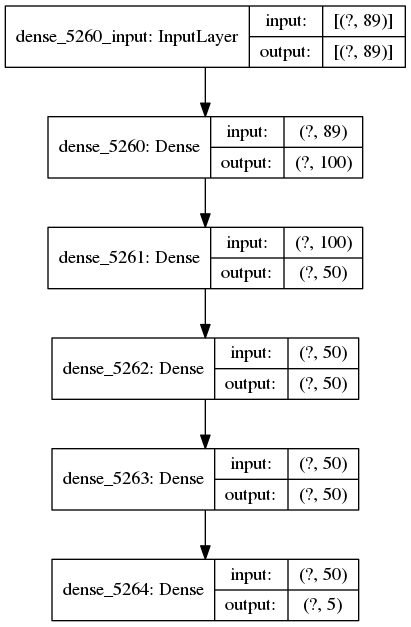

In [73]:
# Export DNN topology
print("Saving topology")
topology_name = "{}_topology.png".format(prefix)
plot_model(cv.best_estimator_.model, to_file=os.path.join(model_dir, topology_name), show_shapes=True)

Scoring on holdout or other dataset

In [ ]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [ ]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [ ]:
# X_h = scaler.transform(X_h)


In [ ]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [ ]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h